<a href="https://colab.research.google.com/github/MMucahit/PyhtonDeepLearningFrancoisChollet/blob/main/Glove_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ham IMDB veri setinin etiketlerini işleme

In [ ]:
import os

In [ ]:
imdb_dir = 'C:\\Users\\nas\\Desktop\\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [ ]:
labels = []
texts = []

In [ ]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding= 'utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)                   

In [ ]:
len(texts)

25000

Veriyi tokenlere ayırma(Tokenizasyon)

In [ ]:
## Metni vektör hailne getirip eğitim ve doğrulama seti olarak ayıralım.
## Elimizde az veri olduğunda öneğitimli wordembedding kullanmak kısmen daha faydalı olabilir.
## Eğitim verisini ilk 200 örnekle sınırlandırağız. Yani sadece 200 örneğe bakarak sınıflandırmayı öğreteceğiz.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
max_len = 100 ## 100 kelimeden sonrasını keser.
training_samples = 200 ## 200 örnekle eğitilecek
validation_samples = 10000 ## 10000 örnekle doğrulanacak.
max_words = 10000

In [ ]:
tokenizer = Tokenizer(num_words= max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print(f'Found {len(word_index)} unique tokens')

data = pad_sequences(sequences, maxlen= max_len)
labels = np.asarray(labels)

print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ', labels.shape)

Found 88582 unique tokens
Shape of data tensor:  (25000, 100)
Shape of label tensor:  (25000,)


In [ ]:
## Veriyi eğitim ve doğrulama olarak ayırmadan önce karştırır.
## Aksi halde sıralı olarak gelecktir veri.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [ ]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Glove WordEmbedding ayrıştırma

In [ ]:
glove_dir = os.path.join(imdb_dir,'glove')

In [ ]:
embedding_index = {}

f = open(os.path.join(glove_dir,'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype= 'float32')
    embedding_index[word] = coefs
f.close()

print(f'Found {len(embedding_index)} word vectors.')

Found 400000 word vectors.


Glove kelime matrisini oluşturma

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Model Oluşturma

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length= max_len))
model.add(Flatten())
model.add(Dense(32, activation= 'relu'))
model.add(Dense(1, activation= 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_matrix]) ## Glove modele dahil edildi
model.layers[0].trainable = False ## Öneğitimli olduğu için backward dan etkilenmemesi için dondurduk

In [ ]:
print('This is the number of trainable weights', len(model.trainable_weights))

This is the number of trainable weights 4


Modele Eğitme

In [ ]:
model.compile(optimizer= 'rmsprop', loss= 'binary_crossentropy', metrics= ['accuracy'])
history = model.fit(x_train, y_train, epochs= 10, batch_size= 32, validation_data= (x_val,y_val))
model.save_weights('pre_trained_model_glove.h5')

Epoch 1/10
7/7 [==============================] - 2s 254ms/step - loss: 1.6248 - accuracy: 0.5108 - val_loss: 0.6898 - val_accuracy: 0.5398
Epoch 2/10
7/7 [==============================] - 1s 168ms/step - loss: 0.6338 - accuracy: 0.6705 - val_loss: 0.8905 - val_accuracy: 0.5027
Epoch 3/10
7/7 [==============================] - 1s 149ms/step - loss: 0.6931 - accuracy: 0.6004 - val_loss: 0.7725 - val_accuracy: 0.5033
Epoch 4/10
7/7 [==============================] - 1s 149ms/step - loss: 0.4962 - accuracy: 0.7036 - val_loss: 0.6815 - val_accuracy: 0.5683
Epoch 5/10
7/7 [==============================] - 1s 209ms/step - loss: 0.3426 - accuracy: 0.9822 - val_loss: 0.9785 - val_accuracy: 0.5105
Epoch 6/10
7/7 [==============================] - 1s 200ms/step - loss: 0.6009 - accuracy: 0.7350 - val_loss: 0.7827 - val_accuracy: 0.5424
Epoch 7/10
7/7 [==============================] - 1s 197ms/step - loss: 0.1532 - accuracy: 0.9855 - val_loss: 1.1209 - val_accuracy: 0.5092
Epoch 8/10
7/7 [====

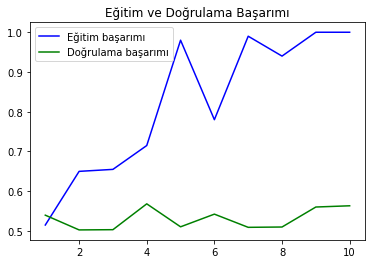

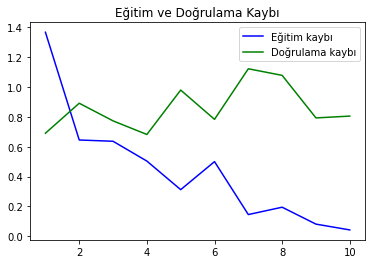

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label= 'Eğitim başarımı')
plt.plot(epochs, val_acc, 'g', label= 'Doğrulama başarımı')
plt.title('Eğitim ve Doğrulama Başarımı')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label= 'Eğitim kaybı')
plt.plot(epochs, val_loss, 'g', label= 'Doğrulama kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()

plt.show()

WordEmbeding Olmadan Aynı Modeli Eğitme

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length= max_len))
model.add(Flatten())
model.add(Dense(32, activation= 'relu'))
model.add(Dense(1, activation= 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('This is the number of trainable weights', len(model.trainable_weights))

This is the number of trainable weights 5


In [ ]:
model.compile(optimizer= 'rmsprop', loss= 'binary_crossentropy', metrics= ['accuracy'])
history = model.fit(x_train, y_train, epochs= 10, batch_size= 32, validation_data= (x_val,y_val))
model.save_weights('pre_trained_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 181ms/step - loss: 0.6917 - accuracy: 0.5072 - val_loss: 0.6922 - val_accuracy: 0.5208
Epoch 2/10
7/7 [==============================] - 1s 168ms/step - loss: 0.5154 - accuracy: 0.9835 - val_loss: 0.7011 - val_accuracy: 0.5295
Epoch 3/10
7/7 [==============================] - 1s 140ms/step - loss: 0.3026 - accuracy: 0.9806 - val_loss: 0.7071 - val_accuracy: 0.5337
Epoch 4/10
7/7 [==============================] - 1s 141ms/step - loss: 0.1401 - accuracy: 0.9823 - val_loss: 0.7061 - val_accuracy: 0.5362
Epoch 5/10
7/7 [==============================] - 1s 138ms/step - loss: 0.0615 - accuracy: 1.0000 - val_loss: 0.7092 - val_accuracy: 0.5395
Epoch 6/10
7/7 [==============================] - 1s 138ms/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.7291 - val_accuracy: 0.5437
Epoch 7/10
7/7 [==============================] - 1s 148ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.7265 - val_accuracy: 0.5406
Epoch 8/10
7/7 [====

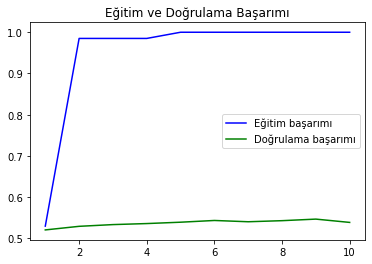

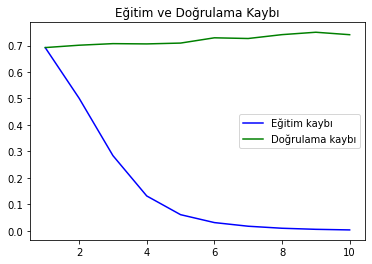

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label= 'Eğitim başarımı')
plt.plot(epochs, val_acc, 'g', label= 'Doğrulama başarımı')
plt.title('Eğitim ve Doğrulama Başarımı')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label= 'Eğitim kaybı')
plt.plot(epochs, val_loss, 'g', label= 'Doğrulama kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()

plt.show()

Test

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding= 'utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)  

In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen= max_len)
y_test = np.asarray(labels)

In [ ]:
## Modeli yükleyip değerlendirdik.
model.load_weights('pre_trained_model_glove.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.8162 - accuracy: 0.5584


[0.8161742687225342, 0.5583999752998352]

In [ ]:
## Modeli yükleyip değerlendirdik.
model.load_weights('pre_trained_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.7414 - accuracy: 0.5393


[0.7414432764053345, 0.5393199920654297]

In [ ]:
## Öneğitimli model daha başarılı ama 200 örnek üzerinde eğittiğimiz için başarım düşük.